<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/Alternate_Labs/DL_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to PyTorch

## Deliverable

For this lab, you will submit an IPython notebook via Learning Suite.
This lab will be mostly boilerplate code, but you will be required to implement a few extras.

**NOTE: you almost certainly will not understand most of what's going on in this lab!
That's ok - the point is just to get you going with PyTorch.
We'll be working on developing a deeper understanding of every part of this code
over the course of the next two weeks.**

A major goal of this lab is to help you become conversant in working through PyTorch
tutorials and documentation.
You should turn to the documentation first, but you may google whatever you need, as there are many great PyTorch tutorials online.

This notebook will have four parts:

* Part 1: Your notebook should contain the boilerplate code. See below.

* Part 2: Your notebook should contain a testing loop.

* Part 3: Your notebook should contain a visualization of test/training performance over time.

The resulting image could, for example, look like this:
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?cache=&w=900&h=608&tok=3092fe&media=cs501r_f2018:lab2.png)

* Part 4: Your notebook should contain the completed microtasks and pass all the asserts.

See the assigned readings for pointers to documentation on PyTorch.
___

### Grading standards:
Your notebook will be graded on the following:

* 40% Successfully followed lab video and typed in code
* 20% Modified code to include a test/train split
* 20% Modified code to include a visualization of train/test losses
* 10% Tidy and legible figures, including labeled axes where appropriate
* 10% Correct solutions to the microtasks
___

### Description
Throughout this class, we will be using PyTorch to implement our deep neural networks. 
PyTorch is a deep learning framework that handles the low-level details of 
GPU integration and automatic differentiation.

The goal of this lab is to help you become familiar with PyTorch. 
The four parts of the lab are outlined above.

For part 1, you should watch the video below, and type in the code as it is explained to you.

A more detailed outline of Part 1 is below.

For part 2, you must add a validation (or testing) loop using the 
FashionMNIST dataset with train=False

For part 3, you must plot the loss values.

For part 4, you must complete the microtasks and pass all asserts.

Optional: Demonstrate overfitting on the training data.

The easiest way to do this is to limit the size of your training dataset 
so that it only returns a single batch (i.e. len(dataloader) == batch_size, 
and train for multiple epochs. For example,
I set my batch size to 42, and augmented my dataloader to produce only 42 
unique items by overwriting the len function to return 42. 
In my training loop, I performed a validation every epoch which basically corresponded 
to a validation every step.

In practice, you will normally compute your validation loss every n steps, 
rather than at the end of every epoch. This is because some epochs can take hours, 
or even days and you don’t often want to wait that long to see your results.

Testing your algorithm by using a single batch and training until overfitting 
is a great way of making sure that your model and optimizer are working the way they should!

___

### Part 0
Watch Tutorial Video

[https://youtu.be/E76hLX9WCLE](https://youtu.be/E76hLX9WCLE)

**TODO:**
* Watch video

**DONE:**

___

### Part 1
Your notebook should contain the boilerplate code. See below.

**TODO:**

* Replicate boilerplate from the video

**DONE:**

___

### Part 2
Your notebook should contain a testing (validation) loop.

**TODO:**

* Add a testing (validation) loop

**DONE:**

In [ ]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
 
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

class LinearNetwork(nn.Module):
    def __init__(self, dataset):
        super(LinearNetwork, self).__init__()
        x, y = dataset[0]
        c, h, w = x.size()
        out_dim = 10
        
        self.net = nn.Sequential(nn.Linear(c*h*w, 1000),
                                nn.ReLU(),
                                nn.Linear(1000,out_dim))
        
    def forward(self,x):
        n,c,h,w = x.size()
        flattened = x.view(n, c*h*w)
        return self.net(flattened)
    
    

class NewNetwork(nn.Module):
    def __init__(self):
        super(NewNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28) # flatten the input
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x



class FashionMNISTProcessedDataset(Dataset):
    def __init__(self, root, train = True):
        self.data = datasets.FashionMNIST(root, train=train,
                                         transform=transforms.ToTensor(),
                                         download=True)
        
    def __getitem__(self,i):
        x,y = self.data[i]
        return x,y
    
    def __len__(self):
        return len(self.data)
        

In [52]:
def train_model(dataset, model, num_epochs = 10,  batch_size = 42):
    # Split the dataset into training and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Instantiate the data loaders
    train_loader = DataLoader(train_dataset, batch_size = 42, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size = 42)
    
    model = model.cuda()
    
    #optimizer and objective
    optimizer = optim.SGD(model.parameters(), lr = 1e-4)
    objective = torch.nn.CrossEntropyLoss()

    #create empty arrays to store graph data
    train_losses = []
    validation_losses = [] 
    accuracy_list = []

    loop = tqdm(total=len(train_loader) * num_epochs, position = 0)
    accuracy = 0
    epoch_num = 0
    #cycle through each epoch
    for epoch in range(num_epochs):
        epoch_num += 1
        #train
        batch = 0
        for x, y_truth in train_loader:
            #learn
            x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

            optimizer.zero_grad()

            y_hat = model(x)
            loss = objective(y_hat, y_truth)
            
            #only save the even epochs values to save on time significantly
            if epoch % 2 == 0 and batch == 0:
                train_losses.append(loss.item())
                validation_loss_list = []
                for val_x, val_y_truth in validation_loader:
                    val_x, val_y_truth = val_x.cuda(non_blocking=True), val_y_truth.cuda(non_blocking=True)
                    val_y_hat = model(val_x)
                    validation_loss_list.append(objective(val_y_hat, val_y_truth))
                validation_losses.append((sum(validation_loss_list)/float(len(validation_loss_list))).item())

                # Calculate accuracy
                y_hat_labels = torch.argmax(y_hat, dim=1)
                accuracy = (y_hat_labels == y_truth).float().mean().item()
                accuracy_list.append(accuracy)

            loop.set_description('epoch:{} batch:{} loss:{:.4f} val_loss:{:.4f} accuracy:{:.4f}'.format(epoch_num, batch, loss.item(), validation_losses[-1], accuracy))

            loss.backward()
            optimizer.step()
            batch += 1
    return accuracy_list, train_losses, validation_losses



___

### Part 3
Your notebook should contain a visualization of test/training
performance over time. Use matplotlib.pyplot, and label the graph's axes.

**TODO:**
* Add a visualization of test/train performance (i.e. loss) over time.

**DONE:**


In [55]:
#Linear Model
# Load the dataset
dataset = FashionMNISTProcessedDataset('tmp/fashionmnist', train=True)
#define model
model = LinearNetwork(dataset)
#define initial variables
num_epochs = 100
batch_size = 42
accuracy_list, train_losses, validation_losses = train_model(dataset, model, num_epochs,  batch_size)

#New Network
dataset = FashionMNISTProcessedDataset('tmp/fashionmnist', train=True)
#define new model
model = NewNetwork()
num_epochs = 100
batch_size = 42
new_accuracy_list, new_train_losses, new_validation_losses = train_model(dataset, model, num_epochs,  batch_size)

epoch:100 batch:1142 loss:0.7397 val_loss:0.6642 accuracy:0.8095:   0%|          | 0/114300 [17:24<?, ?it/s]
epoch:100 batch:1142 loss:0.8607 val_loss:0.8362 accuracy:0.6905:   0%|          | 0/114300 [17:11<?, ?it/s]


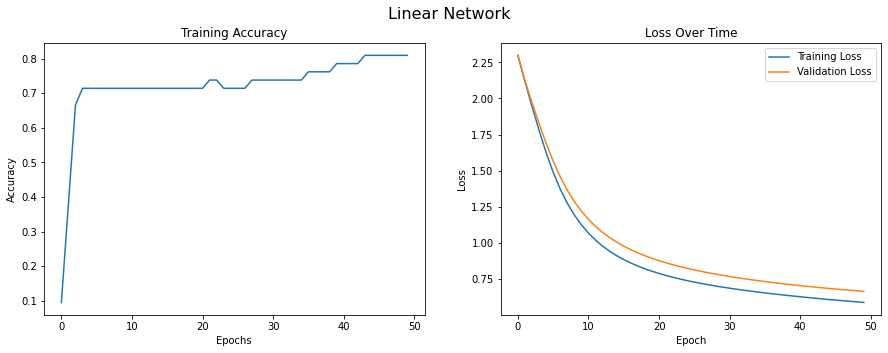

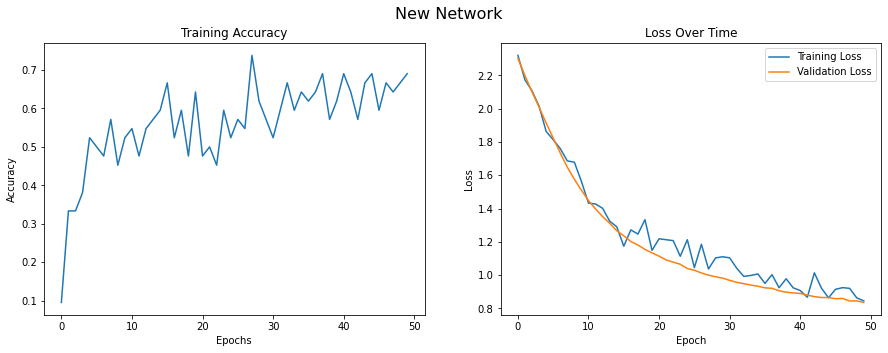

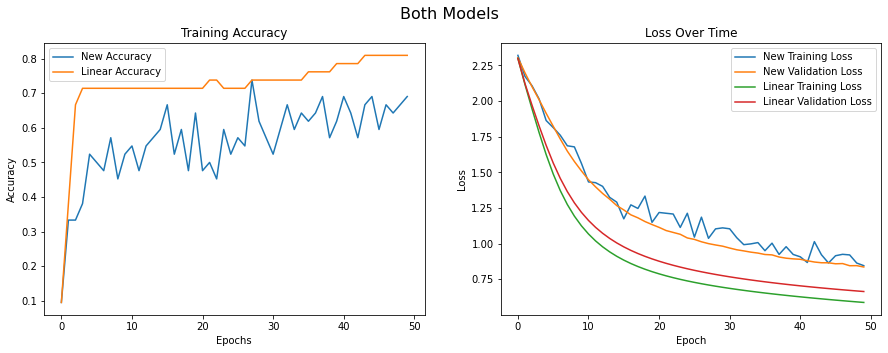

In [56]:
#Linear Model graph
#plot accuracy graph
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(accuracy_list)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training Accuracy')

#plot loss graph
axs[1].plot(train_losses, label='Training Loss')
axs[1].plot(validation_losses, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].set_title("Loss Over Time")
fig.suptitle('Linear Network', fontsize=16)
plt.show()

#New Model graph
#plot accuracy
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(new_accuracy_list)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training Accuracy')

#plot loss
axs[1].plot(new_train_losses, label='Training Loss')
axs[1].plot(new_validation_losses, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].set_title("Loss Over Time")
fig.suptitle('New Network', fontsize=16)
plt.show()

#Both Models 
#plot accuracy
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(new_accuracy_list, label = 'New Accuracy')
axs[0].plot(accuracy_list, label = "Linear Accuracy")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].set_title('Training Accuracy')

#plot loss
axs[1].plot(new_train_losses, label='New Training Loss')
axs[1].plot(new_validation_losses, label='New Validation Loss')
axs[1].plot(train_losses, label='Linear Training Loss')
axs[1].plot(validation_losses, label='Linear Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].set_title("Loss Over Time")
fig.suptitle('Both Models', fontsize=16)
plt.show()

In [20]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, 'SavedLinearModel.pth')


___

### Part 4
Complete the following microtasks to learn some important PyTorch skills.

If you do not know how to complete one of the microtasks, use [PyTorch's documentation](https://pytorch.org/docs/stable/index.html)! PyTorch is very well documented, and you will need to learn how to use the documentation, especially in later labs.

**TODO:**
* Complete microtasks

**DONE:**

### Computation Graph Microtasks

In [57]:
# To understand how PyTorch organizes the computation graph, let's walk through 
# a quick example!

# 1. First, construct a tensor 'a' that contains 10 random floats. 
# This will simulate the output layer of a network. Hint: use `torch.rand`.
a = torch.rand(10)
print(a)
assert a.size() == torch.Size([10])

tensor([0.4936, 0.0488, 0.3394, 0.3629, 0.8909, 0.9460, 0.0280, 0.5816, 0.5913,
        0.5046])


In [59]:
# 2. Now turn 'a' into an `nn.Parameter` so that it be attached to the computation
# graph.
a = nn.Parameter(a)
print(a)
assert type(a) == nn.Parameter

# Notice that our original tensor 'a' is nested inside of a Parameter object.
# The Parameter object knows that it will need to compute gradients at some point.

# No need to do anything here, but this assert should pass.
assert a.requires_grad == True

Parameter containing:
tensor([0.4936, 0.0488, 0.3394, 0.3629, 0.8909, 0.9460, 0.0280, 0.5816, 0.5913,
        0.5046], requires_grad=True)


In [61]:
# 3. Let's run 'a' through a loss function. The output of the loss function is
# just another tensor, but this tensor remembers what operations produced it.
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(a.unsqueeze(0), torch.Tensor([7]).long())
print(loss)

# Now, instruct the network to do a backward pass, by calling '.backward()' on the 
# result of the loss function. We should now be able to see the gradients that 
# were computed for 'a' w.r.t. the loss.
loss.backward()
assert a.grad is not None
print(a.grad)

tensor(2.2411, grad_fn=<NllLossBackward0>)
tensor([ 0.0974,  0.0624,  0.0835,  0.0855,  0.1449,  0.1531,  0.0611, -0.8937,
         0.1074,  0.0985])


In [63]:
# 4. If we were to use 'a' in another operation, this might affect the computation graph.
# To make sure that you are not adversly affecting the computation graph, call
# `.detach()` on 'a' and assign the result to a new variable 'b'.

b = a.detach()
print(a)
print(b)
assert a.requires_grad == True
assert b.requires_grad == False

Parameter containing:
tensor([0.4936, 0.0488, 0.3394, 0.3629, 0.8909, 0.9460, 0.0280, 0.5816, 0.5913,
        0.5046], requires_grad=True)
tensor([0.4936, 0.0488, 0.3394, 0.3629, 0.8909, 0.9460, 0.0280, 0.5816, 0.5913,
        0.5046])
